<a href="https://colab.research.google.com/github/Deland78/KP_Lead_Scoring_Colab/blob/main/KP_Lead_Scoring_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KP Lead Scoring Model\n
Custom lead scoring model built for education leads requiring sales follow-up.

In [44]:

# --- COMET setup  ---
%pip install -q comet_ml

import comet_ml

exp = None
try:
    comet_ml.login()
    exp = comet_ml.start(
        workspace="David-Eland",
        project_name="kp-lead-scoring-model"
    )
    if exp is not None:
        exp.set_name("250920-E2-regression-DE_Cleaned")
        exp.add_tags(["colab", "lead-scoring", "baseline"])
        # Logs code from the file using this method.
        exp.log_code()
except Exception as comet_exc:
    print(f"Comet ML logging disabled: {comet_exc}")
# --- END Comet setup ---


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/david-eland/kp-lead-scoring-model/0415369729f94e149311558da8706130

COMET WARNING: unable to find caller source code in a jupyter notebook; ignoring


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import joblib
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_columns', None)

DEFAULT_INTENT_SCORE = 2
DEFAULT_TIMING_SCORE = 3
DEFAULT_CHANNEL_SCORE = 3
DEFAULT_EDUCATION_SCORE = 3

INTENT_SCORES = {
    'Ready to enrol': 10,
    'Ready to enroll': 10,
    'Readytoenrol': 10,
    'Looking for more information': 6,
    'Researching options': 3,
    'Unknown': 2,
    'unsure': 2,
}

TIMING_SCORES = {
    'within 3 months': 8,
    'within 6 months': 5,
    'within 12 months': 2,
    '12 months plus': 1,
    'unsure': 3,
}

CHANNEL_SCORES = {
    'Unknown': 8,
    'Referral': 7,
    'Traditional': 6,
    'Corporate': 5,
    'SEO': 3,
    'Affinity': 2,
    'Email List': 1,
    'PPI': 1,
    'PPC': 3,
}

EDUCATION_SCORES = {
    'Graduate / Masters Degree': 6,
    'Postgraduate Diploma': 5,
    'Bachelors Degree': 4,
    'Diploma': 3,
    'Year 12': 2,
    'Unknown': 3,
}

CONVERTED_VALUE_MAP = {
    'yes': 1,
    'y': 1,
    'true': 1,
    '1': 1,
    'no': 0,
    'n': 0,
    'false': 0,
    '0': 0,
}

def _build_lookup(mapping):
    return {str(key).strip().casefold(): value for key, value in mapping.items()}

INTENT_SCORE_LOOKUP = _build_lookup(INTENT_SCORES)
TIMING_SCORE_LOOKUP = _build_lookup(TIMING_SCORES)
CHANNEL_SCORE_LOOKUP = _build_lookup(CHANNEL_SCORES)
EDUCATION_SCORE_LOOKUP = _build_lookup(EDUCATION_SCORES)



REQUIRED_COLUMNS = [
    'Intent To Enroll',
    'When Like To Begin Studying',
    'Channel',
    'Opportunity Count',
    'Highest Level Of Education',
    'Converted',
]

def _map_value_to_score(value, lookup, default):
    if pd.isna(value):
        return default
    key = str(value).strip().casefold()
    return lookup.get(key, default)


In [47]:
# Load the cleaned data
DATASET_PATH = '/content/drive/Shareddrives/Product-Development/Lead-Scoring/Korab/DE_Lead_Scoring_Data_Cleaned.csv'
df = pd.read_csv(DATASET_PATH)
df.columns = df.columns.str.strip()
# df = df.rename(columns={alias: canonical for alias, canonical in COLUMN_ALIASES.items() if alias in df.columns})

if 'Converted' not in df.columns:
    raise KeyError("The required 'Converted' column is missing from the dataset.")

converted_numeric = pd.to_numeric(df['Converted'], errors='coerce')
if converted_numeric.isna().any():
    normalized = df['Converted'].astype(str).str.strip().str.lower()
    converted_numeric = normalized.map(CONVERTED_VALUE_MAP)
if converted_numeric.isna().any():
    raise ValueError("The 'Converted' column must contain numeric or binary yes/no values.")
df['Converted'] = converted_numeric.astype(int)

print(f"Dataset path: {DATASET_PATH}")
print(f"Dataset shape: {df.shape}")
conversion_rate = (df['Converted'].mean() * 100)
print(f"Conversion rate: {conversion_rate:.2f}%")
print(f"Total conversions: {df['Converted'].sum():,}")

if 'exp' in globals() and exp is not None:
    class_counts = df['Converted'].value_counts().to_dict()
    exp.log_other('dataset_path', DATASET_PATH)
    exp.log_other('dataset_shape', f"{df.shape[0]}x{df.shape[1]}")
    exp.log_metric('dataset_rows', int(df.shape[0]))
    exp.log_metric('dataset_columns', int(df.shape[1]))
    exp.log_metric('conversion_rate', float(df['Converted'].mean()))
    for label, count in class_counts.items():
        exp.log_metric(f'class_count_{label}', int(count))
    exp.log_other('class_balance', json.dumps(class_counts))

Dataset path: /content/drive/Shareddrives/Product-Development/Lead-Scoring/Korab/DE_Lead_Scoring_Data_Cleaned.csv
Dataset shape: (30000, 23)
Conversion rate: 6.37%
Total conversions: 1,911


In [48]:

def create_lead_scoring_features(df):
    'Create engineered features for lead scoring.'
    df_features = df.copy()
    df_features.columns = df_features.columns.str.strip()

    missing_columns = [col for col in REQUIRED_COLUMNS if col not in df_features.columns]
    if missing_columns:
        raise KeyError(f"Missing required columns for feature engineering: {missing_columns}")

    df_features['Intent_Score'] = df_features['Intent To Enroll'].apply(
        lambda value: _map_value_to_score(value, INTENT_SCORE_LOOKUP, DEFAULT_INTENT_SCORE)
    )
    df_features['Timing_Score'] = df_features['When Like To Begin Studying'].apply(
        lambda value: _map_value_to_score(value, TIMING_SCORE_LOOKUP, DEFAULT_TIMING_SCORE)
    )
    df_features['Channel_Score'] = df_features['Channel'].apply(
        lambda value: _map_value_to_score(value, CHANNEL_SCORE_LOOKUP, DEFAULT_CHANNEL_SCORE)
    )
    opportunity_counts = pd.to_numeric(df_features['Opportunity Count'], errors='coerce').fillna(0)
    df_features['Is_Returning_Contact'] = (opportunity_counts > 1).astype(int)
    df_features['Education_Score'] = df_features['Highest Level Of Education'].apply(
        lambda value: _map_value_to_score(value, EDUCATION_SCORE_LOOKUP, DEFAULT_EDUCATION_SCORE)
    )

    return df_features

# Apply feature engineering
df_features = create_lead_scoring_features(df)
print('Feature engineering complete!')

if 'exp' in globals() and exp is not None:
    exp.log_other('feature_engineering_function', 'create_lead_scoring_features')


Feature engineering complete!


In [49]:

# Select features and train model
model_features = ['Intent_Score', 'Timing_Score', 'Channel_Score', 'Is_Returning_Contact', 'Education_Score']

if 'exp' in globals() and exp is not None:
    exp.log_other('model_feature_order', json.dumps(model_features))
    exp.log_metric('feature_count', len(model_features))

X = df_features[model_features]
y = df_features['Converted']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'exp' in globals() and exp is not None:
    split_recipe = {
        'test_size': 0.2,
        'random_state': 42,
        'stratify': 'Converted',
    }
    exp.log_other('train_test_split', json.dumps(split_recipe))
    exp.log_metric('train_samples', int(len(X_train)))
    exp.log_metric('test_samples', int(len(X_test)))
    exp.log_metric('train_positive', int(y_train.sum()))
    exp.log_metric('test_positive', int(y_test.sum()))
    exp.log_metric('train_negative', int((y_train == 0).sum()))
    exp.log_metric('test_negative', int((y_test == 0).sum()))

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

if 'exp' in globals() and exp is not None:
    exp.log_other('scaler', 'StandardScaler')

# Train model
model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

if 'exp' in globals() and exp is not None:
    exp.log_parameters({f'log_reg__{key}': value for key, value in model.get_params().items()})

model.fit(X_train_scaled, y_train)

print('Model training complete!')


Model training complete!


=== MODEL PERFORMANCE ===
Accuracy: 0.5738
ROC-AUC: 0.5773
Precision: 0.0793
Recall: 0.5366
F1 Score: 0.1382

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.58      0.72      5618
           1       0.08      0.54      0.14       382

    accuracy                           0.57      6000
   macro avg       0.51      0.56      0.43      6000
weighted avg       0.89      0.57      0.68      6000



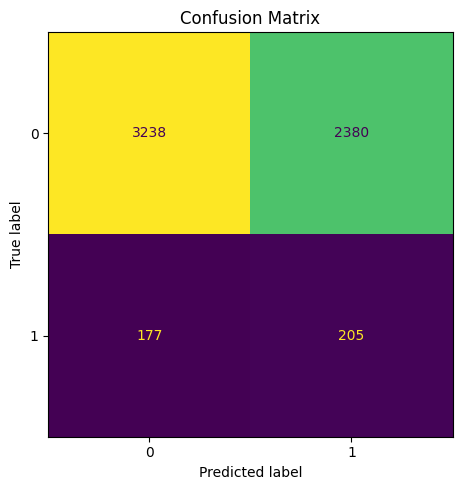


=== FEATURE IMPORTANCE ===
                Feature  Coefficient  Abs_Importance
1          Timing_Score     0.228840        0.228840
2         Channel_Score     0.197514        0.197514
4       Education_Score    -0.135525        0.135525
3  Is_Returning_Contact     0.115258        0.115258
0          Intent_Score     0.053308        0.053308
Model and scaler saved to disk.


In [50]:
    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print('=== MODEL PERFORMANCE ===')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print('\nClassification Report:')
    print(report)

    class_labels = [str(label) for label in model.classes_]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    if 'exp' in globals() and exp is not None:
        exp.log_figure(figure_name='confusion_matrix', figure=fig)
    plt.show()
    plt.close(fig)

    importance_df = pd.DataFrame({
        'Feature': model_features,
        'Coefficient': model.coef_[0],
        'Abs_Importance': np.abs(model.coef_[0]),
    }).sort_values('Abs_Importance', ascending=False)

    print('\n=== FEATURE IMPORTANCE ===')
    print(importance_df)

    joblib.dump(model, 'model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print('Model and scaler saved to disk.')

    if 'exp' in globals() and exp is not None:
        exp.log_metric('accuracy', float(accuracy))
        exp.log_metric('roc_auc', float(roc_auc))
        exp.log_metric('precision', float(precision))
        exp.log_metric('recall', float(recall))
        exp.log_metric('f1_score', float(f1))
        exp.log_confusion_matrix(matrix=cm.tolist(), labels=class_labels)
        exp.log_other('classification_report', report)
        exp.log_table('feature_coefficients.csv', importance_df)
        exp.log_other('model_coefficients', importance_df.to_json(orient='records'))
        exp.log_asset('model.pkl')
        exp.log_asset('scaler.pkl')

In [51]:
def score_lead(intent_to_enroll, when_like_to_begin, channel, highest_education, opportunity_count):
    'Score a new lead (0-100 scale).'

    intent_score = _map_value_to_score(intent_to_enroll, INTENT_SCORE_LOOKUP, DEFAULT_INTENT_SCORE)
    timing_score = _map_value_to_score(when_like_to_begin, TIMING_SCORE_LOOKUP, DEFAULT_TIMING_SCORE)
    channel_score = _map_value_to_score(channel, CHANNEL_SCORE_LOOKUP, DEFAULT_CHANNEL_SCORE)
    education_score = _map_value_to_score(highest_education, EDUCATION_SCORE_LOOKUP, DEFAULT_EDUCATION_SCORE)

    if pd.isna(opportunity_count):
        opportunity_count_value = 0
    else:
        try:
            opportunity_count_value = int(float(opportunity_count))
        except (TypeError, ValueError):
            opportunity_count_value = 0
    is_returning = 1 if opportunity_count_value > 1 else 0

    features = np.array([[intent_score, timing_score, channel_score, is_returning, education_score]], dtype=float)

    features_scaled = scaler.transform(features)
    probability = model.predict_proba(features_scaled)[0, 1]

    return float((probability * 100).round(2))

print('Lead scoring function ready!')

# Test examples
print('''
=== SCORING EXAMPLES ===''')
print(f"High priority: {score_lead('Ready to enrol', 'within 3 months', 'Referral', 'Bachelors Degree', 1)}")
print(f"Medium priority: {score_lead('Researching options', 'within 6 months', 'SEO', 'Diploma', 1)}")
print(f"Low priority: {score_lead('Researching options', 'within 12 months', 'Email List', 'Year 12', 1)}")

Lead scoring function ready!

=== SCORING EXAMPLES ===
High priority: 85.33
Medium priority: 49.05
Low priority: 28.5


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [52]:
    # Dataset overview
    print('=== DATASET OVERVIEW ===')
    print(f'Shape: {df.shape}')
    print(f"Conversion rate: {df['Converted'].mean():.4f}")

    print('''
=== COLUMN SUMMARY ===''')
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        print(f'''
--- {col} ---''')
        print(f'Data type: {df[col].dtype}')
        print(f"Missing values: {missing_count} ({missing_count / len(df) * 100:.1f}%)")
        print(f'Unique values: {df[col].nunique()}')

    # COMET End Experiment
    if 'exp' in globals() and exp is not None:
        exp.end()
    else:
        print("COMET experiment not initialized or already ended.")

=== DATASET OVERVIEW ===
Shape: (30000, 23)
Conversion rate: 0.0637

=== COLUMN SUMMARY ===

--- OpportunityId ---
Data type: object
Missing values: 0 (0.0%)
Unique values: 30000

--- Created On Datetime ---
Data type: object
Missing values: 0 (0.0%)
Unique values: 29798

--- Applied Datetime ---
Data type: object
Missing values: 28089 (93.6%)
Unique values: 1907

--- Lead to Applied Days ---
Data type: float64
Missing values: 28089 (93.6%)
Unique values: 245

--- Partner Code ---
Data type: object
Missing values: 0 (0.0%)
Unique values: 13

--- Program Code ---
Data type: object
Missing values: 0 (0.0%)
Unique values: 181

--- Channel ---
Data type: object
Missing values: 0 (0.0%)
Unique values: 12

--- Source ---
Data type: object
Missing values: 1014 (3.4%)
Unique values: 17

--- SubSource ---
Data type: object
Missing values: 6290 (21.0%)
Unique values: 15

--- Lead Group ---
Data type: object
Missing values: 0 (0.0%)
Unique values: 8

--- Campaign Source Code ---
Data type: object

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 250920-E2-regression-DE_Cleaned
COMET INFO:     url                   : https://www.comet.com/david-eland/kp-lead-scoring-model/0415369729f94e149311558da8706130
COMET INFO:   Metrics:
COMET INFO:     accuracy        : 0.5738333333333333
COMET INFO:     class_count_0   : 28089
COMET INFO:     class_count_1   : 1911
COMET INFO:     conversion_rate : 0.0637
COMET INFO:     dataset_columns : 23
COMET INFO:     dataset_rows    : 30000
COMET INFO:     f1_score        : 0.1381867205931918
COMET INFO:     feature_count   : 5
COMET INFO:     precision       : 0.07930367504835589
COMET INFO:     recall          : 0.5366492146596858
COMET INFO:     roc_auc     